# Experimentos para os dados textuais

In [1]:
import datetime
import re
import json
import yaml
import sys
import os
import logging
import logging.config
import time
import multiprocessing
from collections import OrderedDict
import requests
import string
import unicodedata
import yaml
import warnings
warnings.filterwarnings('ignore')

########################################
# external libs
########################################
import joblib
from joblib import delayed, Parallel

########################################
# ml
########################################
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    balanced_accuracy_score,
    average_precision_score,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    jaccard_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Binarizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

#################################
# VARIÁVEIS GLOBAIS
#################################
N_JOBS = 6
BASE_DIR = './'
DEFAULT_RANDOM_STATE = 42

#################################
# LOGS
#################################
with open(os.path.join(BASE_DIR, 'log.conf.yaml'), 'r') as f:
    config = yaml.safe_load(f.read())
    logging.config.dictConfig(config)

In [2]:
class TextCleaner(BaseEstimator, TransformerMixin):
    stop_words = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no',
                  'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu',
                  'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo',
                  'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem',
                  'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu',
                  'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe',
                  'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes',
                  'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas',
                  'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está',
                  'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam',
                  'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos',
                  'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve',
                  'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse',
                  'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos',
                  'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram',
                  'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos',
                  'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos',
                  'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos',
                  'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem',
                  'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']

    def __init__(self, n_jobs=1):
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sX = pd.Series(X)

        def tratar_texto(t):

            if not t:
                return ''
            if type(t) != str:
                t = str(t)

            t = t.replace('\\n', ' ')
            t = t.replace('null', ' ')
            t = t.lower()
            regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
            t = regex.sub(" ", t)
            lista = t.split()

            # retira stopwords e sinais de pontuação
            lista = [palavra for palavra in lista if palavra not in self.stop_words and palavra not in string.punctuation]

            # retira os dígitos
            lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
            lista = lista.replace('\n', ' ').replace('\r', ' ')
            lista = lista.replace(' o ', ' ').replace(' a ', ' ').replace(' os ', ' ').replace(' as ', ' ')  # retira o, a, os, as que ainda permaneceiam no texto
            lista = re.sub(r" +", ' ', lista)  # retira espaços em excesso

            nfkd = unicodedata.normalize('NFKD', lista)
            lista = u"".join([c for c in nfkd if not unicodedata.combining(c)])  # retira acento

            return lista

        def tratar_serie(s):
            return s.apply(tratar_texto)

        split = np.array_split(sX, self.n_jobs)
        r = Parallel(n_jobs=self.n_jobs, verbose=0)(delayed(tratar_serie)(s) for s in split)
        return pd.concat(r)
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, default_value=0):
        self.feature_names = feature_names
        self.default_value = default_value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # incluir teste para colunas ausentes
        X = X.copy()
        for c in self.feature_names:
            if c not in X.columns:
                X[c] = self.default_value
        return X[self.feature_names]

# Dataset Texto

In [3]:
# dataset não anonimizado
# não será disponibilizado com o código 
# fonte devido a restrições de sigilo institucional
df = pd.read_parquet('dados_nao_anonimizados/df_completo_rotulado.parquet')
df['TextoCompleto'] = df['TxtFatoManifestacao'].str.cat(df['TextoAnexo'], sep=' ').astype(str)
X_txt, y_txt = df[['TextoCompleto']], df['GrauAptidao'].apply(lambda x: 1 if x>50 else 0)

In [4]:
%%time
# preprocessamento do texto (remoção de stopwords, remoção de acentos, remoção de pontuações, remoção de números, transformação de todos os caracteres em lowercase)
X_txt = TextCleaner(n_jobs=N_JOBS).fit_transform(X_txt['TextoCompleto']).to_frame()

Wall time: 30.9 s


In [5]:
X_txt.shape

(1489, 1)

In [6]:
y_txt.shape

(1489,)

In [7]:
%%time

# separação do dataset em treino e teste
X_txt_train, X_txt_test, y_txt_train, y_txt_test = train_test_split(X_txt, y_txt, test_size=.2, random_state=DEFAULT_RANDOM_STATE, stratify=y_txt) 

# utiliza o tf-idf para aprender o vocabulário e pesos a partir dos dados de treinamento
tf_idf = TfidfVectorizer(min_df=5, max_df=.5, max_features=2000)
tf_idf.fit(X_txt_train['TextoCompleto'])

# transforma os datasets de treinamento
X_txt_train_idf = tf_idf.transform(X_txt_train['TextoCompleto'])

Wall time: 10.9 s


In [8]:
%%time

pipeline = Pipeline(steps=[
    ('model', RandomForestClassifier())
])

metrics = ['roc_auc','balanced_accuracy', 'average_precision', 'recall', 'accuracy', 'f1_macro','f1_weighted']

results = [
    
]

model = [
    RandomForestClassifier,
    LogisticRegression,
    XGBClassifier,
    KNeighborsClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    SGDClassifier,
    SVC, 
    NuSVC, 
    LinearSVC,
    BernoulliNB, 
    LGBMClassifier,
    MLPClassifier,
    AdaBoostClassifier,
]

N_ESTIMATORS_ITERATORS = 200
POS_WEIGHT = pd.Series(y_txt_train).value_counts()[0]/pd.Series(y_txt_train).value_counts()[1]
class_weight = {0: 1, 1: POS_WEIGHT}

params = [
    {
        'model__n_estimators': [N_ESTIMATORS_ITERATORS],
        'model__max_depth': [5,7,9],
        'model__min_samples_split': [2,3],
        'model__min_samples_leaf': [1,2],
        'model__class_weight': [class_weight],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__max_samples': [.8, 1],
    },
    {
        'model__penalty' : ['l2'],
        'model__C' : [1],
        'model__solver' : ['liblinear'],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__learning_rate': [0.01],
        'model__n_estimators': [N_ESTIMATORS_ITERATORS],
        'model__subsample' : [.8,.45],
        'model__min_child_weight': [1],
        'model__max_depth': [3,4,7],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__reg_lambda': [2],
        'model__scale_pos_weight': [POS_WEIGHT]
    },
    {
        'model__n_neighbors' : [5,7,9,11],
    },
    {
        'model__n_estimators': [5],
        'model__max_samples': [.8],
        'model__random_state': [DEFAULT_RANDOM_STATE],
    },
    {
        'model__n_estimators': [N_ESTIMATORS_ITERATORS],
        'model__max_samples' : [.8],
        'model__max_depth': [6,7],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__gamma': ['auto'],
        'model__C': [0.5],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__gamma': ['auto'],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
    },
    {
        'model__n_estimators': [N_ESTIMATORS_ITERATORS],
        'model__subsample': [.6,.7,.8,1],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__alpha': [1], 
        'model__max_iter': [50],
    },
    {
    }
]


logging.info('Início')
for m, p in zip(model, params):
    logging.info('Modelo: {}'.format(m.__name__))
    
    p['model'] = [m()]
    
    rskfcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=DEFAULT_RANDOM_STATE)
    cv = GridSearchCV(estimator=pipeline,param_grid=p, cv=rskfcv, n_jobs=N_JOBS, error_score=0, refit=True, scoring='roc_auc', verbose=1)
    cv.fit(X_txt_train_idf, y_txt_train)
    model = cv.best_estimator_
    best_params = cv.best_params_
    
    valores = cross_validate(m(**{k[7:]: v for k,v in best_params.items() if k.startswith('model__')}), X_txt_train_idf, y_txt_train, scoring=metrics, cv=rskfcv, verbose=1)
    cv_scores = {k[5:]: np.mean(v) for k, v in valores.items() if k not in ['fit_time', 'score_time']}

    linha = {
        'Modelo': m.__name__,
        'ScoreTreino': cv.score(X_txt_train_idf, y_txt_train),
        'BestParams': best_params,
        'RawScores': {k[5:]: v for k, v in valores.items() if k not in ['fit_time', 'score_time']}
    }
    linha.update(cv_scores)
    results.append(linha)

logging.info('Fim')

[2021-02-16 19:07:09,944][<timed exec>:<module>:110 INFO] Início
[2021-02-16 19:07:09,945][<timed exec>:<module>:112 INFO] Modelo: RandomForestClassifier
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   24.2s
[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed:   29.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:07:47,227][<timed exec>:<module>:112 INFO] Modelo: LogisticRegression


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.8s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:07:47,756][<timed exec>:<module>:112 INFO] Modelo: XGBClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   47.5s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:09:50,926][<timed exec>:<module>:112 INFO] Modelo: KNeighborsClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:09:51,942][<timed exec>:<module>:112 INFO] Modelo: BaggingClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:10:01,657][<timed exec>:<module>:112 INFO] Modelo: ExtraTreesClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:10:09,848][<timed exec>:<module>:112 INFO] Modelo: SGDClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.8s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:10:10,303][<timed exec>:<module>:112 INFO] Modelo: SVC


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished


[2021-02-16 19:10:27,759][<timed exec>:<module>:112 INFO] Modelo: NuSVC
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.2s finished


[2021-02-16 19:10:41,474][<timed exec>:<module>:112 INFO] Modelo: LinearSVC
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:10:42,216][<timed exec>:<module>:112 INFO] Modelo: BernoulliNB


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[2021-02-16 19:10:42,501][<timed exec>:<module>:112 INFO] Modelo: LGBMClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:   35.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:11:41,712][<timed exec>:<module>:112 INFO] Modelo: MLPClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:12:46,703][<timed exec>:<module>:112 INFO] Modelo: AdaBoostClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   45.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-02-16 19:13:02,238][<timed exec>:<module>:134 INFO] Fim
Wall time: 5min 52s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


In [9]:
df_results_txt = pd.DataFrame(results)
df_results_txt = pd.DataFrame(df_results_txt)
df_results_txt = df_results_txt.sort_values('roc_auc', ascending=False)
df_results_txt

,Modelo,ScoreTreino,BestParams,RawScores,roc_auc,balanced_accuracy,average_precision,recall,accuracy,f1_macro,f1_weighted
2,XGBClassifier,0.976825,"{'model': XGBClassifier(base_score=None, boost...","{'roc_auc': [0.84375, 0.8229166666666666, 0.80...",0.837364,0.739448,0.666132,0.649899,0.781674,0.728654,0.785106
11,LGBMClassifier,0.999982,"{'model': LGBMClassifier(class_weight={0: 1, 1...","{'roc_auc': [0.8125, 0.7697557471264368, 0.797...",0.829600,0.724987,0.658938,0.551411,0.806891,0.733141,0.799132
12,MLPClassifier,0.946317,"{'model': MLPClassifier(alpha=1, max_iter=50),...","{'roc_auc': [0.8362926136363636, 0.78879310344...",0.825113,0.643623,0.645356,0.347681,0.783340,0.657647,0.755353
0,RandomForestClassifier,0.950671,{'model': RandomForestClassifier(class_weight=...,"{'roc_auc': [0.8274147727272727, 0.77693965517...",0.825104,0.694648,0.644965,0.510181,0.781702,0.701716,0.774412
1,LogisticRegression,0.954470,"{'model': LogisticRegression(C=1, class_weight...","{'roc_auc': [0.8327414772727272, 0.79094827586...",0.821915,0.748353,0.640024,0.688306,0.776660,0.729413,0.782604
5,ExtraTreesClassifier,0.939583,{'model': ExtraTreesClassifier(class_weight={0...,"{'roc_auc': [0.8139204545454545, 0.74497126436...",0.819706,0.686288,0.628069,0.523085,0.763221,0.686194,0.759182
8,NuSVC,0.929530,"{'model': NuSVC(class_weight={0: 1, 1: 2.79299...","{'roc_auc': [0.8426846590909091, 0.76544540229...",0.815903,0.642230,0.642972,0.322077,0.793417,0.658890,0.759901
7,SVC,0.847537,"{'model': SVC(C=0.5, class_weight={0: 1, 1: 2....","{'roc_auc': [0.8071732954545454, 0.75574712643...",0.813817,0.500000,0.616197,0.600000,0.448964,0.293007,0.311914
3,KNeighborsClassifier,0.873672,{'model': KNeighborsClassifier(n_neighbors=11)...,"{'roc_auc': [0.8094815340909092, 0.78430316091...",0.803436,0.696309,0.588979,0.510081,0.784181,0.705564,0.777307
13,AdaBoostClassifier,0.954290,{'model': AdaBoostClassifier()},"{'roc_auc': [0.7492897727272727, 0.76185344827...",0.780672,0.685784,0.572725,0.491331,0.777507,0.694122,0.769153


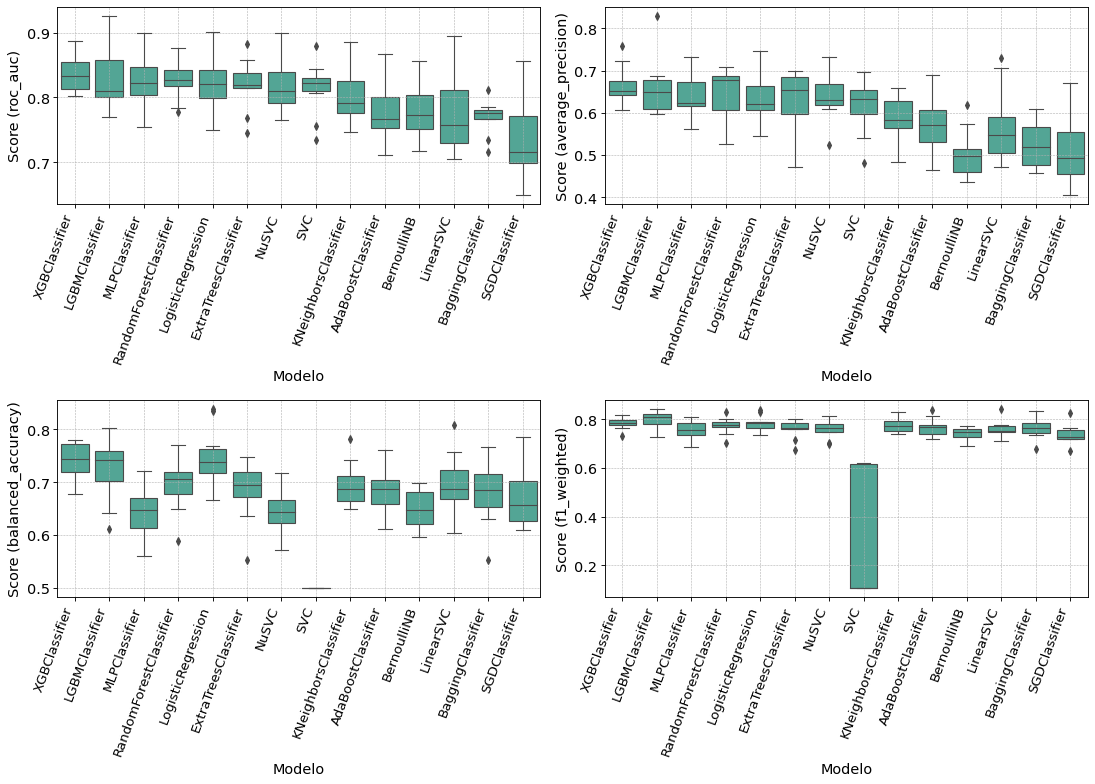

In [10]:
metricas = ['roc_auc', 'average_precision', 'balanced_accuracy', 'f1_weighted']

matplotlib.rcParams.update({'font.size': 13})
fig, axis = plt.subplots(2,2, figsize=(14, 10), dpi=80)

axis = np.ravel(axis)
for i, m in enumerate(metricas):
    df_score = pd.DataFrame({m: s for m, s in zip(df_results_txt['Modelo'], df_results_txt['RawScores'].apply(lambda x: x[m]))})
    df_score = pd.melt(df_score, var_name='Modelo', value_name='Score')
    sns.boxplot(x='Modelo', y='Score', data=df_score, color='#45B39D', linewidth=1, ax=axis[i])
    axis[i].set_xlabel('Modelo')
    axis[i].set_ylabel(f'Score ({m})')
    axis[i].set_xticklabels(labels=df_score['Modelo'].drop_duplicates(), rotation=70, ha='right', fontsize=12)
    axis[i].grid(which='major',linestyle='--', linewidth=0.5, )
    
plt.tight_layout()
# plt.savefig('./docs/tcc/fig_00500_comparacao_score_modelos_texto.png')
plt.show()

# Tunning Hiperparametros

In [11]:
df_results_txt['BestParams'].iloc[0]

{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.01, max_delta_step=None, max_depth=7,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               n_estimators=200, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=2,
               scale_pos_weight=2.7929936305732483, subsample=0.45,
               tree_method=None, validate_parameters=None, verbosity=None),
 'model__learning_rate': 0.01,
 'model__max_depth': 7,
 'model__min_child_weight': 1,
 'model__n_estimators': 200,
 'model__random_state': 42,
 'model__reg_lambda': 2,
 'model__scale_pos_weight': 2.7929936305732483,
 'model__subsample': 0.45}

In [12]:
from skopt import forest_minimize
from sklearn.model_selection import RepeatedStratifiedKFold



def tune_lgbm(params):
    logging.info(params)
    n_estimators = params[0] 
    max_depth = params[1]
    reg_lambda = params[2]
    learning_rate = params[3]
    subsample = params[4]
    reg_alpha = params[5]
    gamma = params[6]
    min_df = params[7]
    max_df = params[8]
    max_features = params[9]
    ngram_range = (1, params[10])
    
    tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, ngram_range=ngram_range)
    X_txt_train_idf = tfidf.fit_transform(X_txt_train['TextoCompleto'])
    
    scale_pos_weight = y_txt_train.value_counts()[0]/y_txt_train.value_counts()[1]
    
    model = XGBClassifier(base_score=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=gamma,
               importance_type='gain', interaction_constraints=None,
               learning_rate=learning_rate, max_delta_step=None, max_depth=max_depth,
               n_estimators=n_estimators, n_jobs=None, num_parallel_tree=None,
               random_state=DEFAULT_RANDOM_STATE, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
               scale_pos_weight=scale_pos_weight, subsample=subsample, 
               validate_parameters=None, verbosity=None)
    
    rskfcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=DEFAULT_RANDOM_STATE)
    score = cross_val_score(model, X_txt_train_idf, y_txt_train, scoring='roc_auc', cv=rskfcv)
    return -np.mean(score)

space = [
    (100, 1000), # n_estimators
    (1, 20), # max_depth
    (0.01, 5.0), # reg_lambda
    (0.0001, 0.03), # learning_rate
    (0.4, 1.), # subsample
    (0.01, 5.0), # reg_alpha
    (0.01, 5.0), # gamma
    (2, 5), # min_df
    (0.5, 1.0), # max_df
    (100, 5000), # max_features
    (1, 2), # ngram_range
]
#alterar qdo colocar no HPC
res = forest_minimize(tune_lgbm, space, random_state=DEFAULT_RANDOM_STATE, n_random_starts=20, n_calls=50, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[535, 15, 3.662649769638912, 0.017999888677491395, 0.49361118426546197, 0.7884126564776514, 0.2998372247193154, 5, 0.666854305569511, 3019, 2]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 113.2001
Function value obtained: -0.8336
Current minimum: -0.8336
Iteration No: 2 started. Evaluating function at random point.
[230, 2, 3.612773873611456, 0.028162725999570933, 0.4004672595046086, 4.961135680863176, 3.091232733042306, 3, 0.762378215816119, 4943, 1]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 29.2016
Function value obtained: -0.8273
Current minimum: -0.8336
Iteration No: 3 started. Evaluating function at random point.
[660, 10, 0.24286165943594104, 0.02921529001335963, 0.5396628042581826, 0.46212610831877593, 3.095746186572106, 5, 0.7571172192068059, 1628, 1]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 82.9850
Function value obtained: -0.8322
Current mi

In [13]:
res.x

[164,
 7,
 2.122773388724785,
 0.011906957393449534,
 0.576092904830823,
 0.08025831534827145,
 1.0022235964031379,
 5,
 0.8645035840204938,
 4574,
 1]

In [37]:
params = [759, 4, 4.038900470867496, 0.022685086880347725, 0.7851344045803921, 0.1308550296924623, 0.022216673300650254, 5, 0.6568820361887584, 4358, 1]
params = [561, 8, 4.224223904903976, 0.02244487129310769, 0.7238152794334479, 2.937888316662603, 4.82662398324805, 5, 0.7713480415791243, 2162, 1]
params = res.x

scale_pos_weight = pd.Series(y_txt_train).value_counts()[0]/pd.Series(y_txt_train).value_counts()[1]
n_estimators = params[0] 
max_depth = params[1]
reg_lambda = params[2]
learning_rate = params[3]
subsample = params[4]
reg_alpha = params[5]
gamma = params[6]
min_df = params[7]
max_df = params[8]
max_features = params[9]
ngram_range = (1, params[10])

tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, ngram_range=ngram_range)
tfidf.fit(X_txt_train['TextoCompleto'])

X_txt_train_idf = tfidf.transform(X_txt_train['TextoCompleto'])
X_txt_test_idf = tfidf.transform(X_txt_test['TextoCompleto'])

scale_pos_weight = y_txt_train.value_counts()[0]/y_txt_train.value_counts()[1]

model = XGBClassifier(base_score=None, colsample_bylevel=None,
           colsample_bynode=None, colsample_bytree=None, gamma=gamma,
           gpu_id=None, importance_type='gain', interaction_constraints=None,
           learning_rate=learning_rate, max_delta_step=None, max_depth=max_depth,
           n_estimators=n_estimators, n_jobs=None, num_parallel_tree=None,
           random_state=DEFAULT_RANDOM_STATE, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
           scale_pos_weight=scale_pos_weight, subsample=subsample, tree_method=None,
           validate_parameters=None, verbosity=None)

model.fit(X_txt_train_idf, y_txt_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0022235964031379,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.011906957393449534, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=164, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0.08025831534827145, reg_lambda=2.122773388724785,
              scale_pos_weight=2.7929936305732483, subsample=0.576092904830823,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
df_train_save = X_txt_train_idf.copy()
df_train_save = pd.DataFrame(df_train_save.todense(), columns=[str(l) for l in range(X_txt_train_idf.shape[1])])
df_train_save['LABEL'] = y_txt_train.values
df_train_save.to_parquet('datasets/dataset_tfidf_train.parquet')
df_train_save.head()

,0,1,2,3,4,5,6,7,8,9,...,4565,4566,4567,4568,4569,4570,4571,4572,4573,LABEL
0,0.0,0.0,0.0,0.001737,0.014699,0.000847,0.0,0.0,0.000581,0.004343,...,0.000000,0.002744,0.0,0.0,0.000000,0.004362,0.0,0.000000,0.00000,1
1,0.0,0.0,0.0,0.002002,0.012345,0.000000,0.0,0.0,0.000000,0.009011,...,0.004935,0.004744,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,1
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0
4,0.0,0.0,0.0,0.001663,0.026545,0.000000,0.0,0.0,0.001669,0.011229,...,0.000000,0.001478,0.0,0.0,0.000457,0.000000,0.0,0.002754,0.00265,1


In [39]:
df_test_save = X_txt_test_idf.copy()
df_test_save = pd.DataFrame(df_test_save.todense(), columns=[str(l) for l in range(X_txt_test_idf.shape[1])])
df_test_save['LABEL'] = y_txt_test.values
df_test_save.to_parquet('datasets/dataset_tfidf_test.parquet')
df_test_save.head()

,0,1,2,3,4,5,6,7,8,9,...,4565,4566,4567,4568,4569,4570,4571,4572,4573,LABEL
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.386005,0.0,0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
4,0.0,0.0,0.0,0.072319,0.0,0.0,0.0,0.0,0.145104,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0


In [40]:
from sklearn.model_selection import RepeatedStratifiedKFold
rskfcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=DEFAULT_RANDOM_STATE)
score = cross_val_score(model, X_txt_train_idf, y_txt_train, scoring='roc_auc', cv=rskfcv)

In [41]:
score

array([0.83096591, 0.8204023 , 0.83117816, 0.82399425, 0.8856305 ,
       0.83101173, 0.80975073, 0.86730205, 0.86070381, 0.83577713])

In [42]:
np.mean(score)

0.8396716574813766

In [43]:
p = model.predict(X_txt_test_idf)

In [44]:
balanced_accuracy_score(y_txt_test, model.predict(X_txt_test_idf) )

0.7111888111888112

In [45]:
print(classification_report(y_txt_test, model.predict(X_txt_test_idf) ))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       220
           1       0.57      0.58      0.57        78

    accuracy                           0.78       298
   macro avg       0.71      0.71      0.71       298
weighted avg       0.78      0.78      0.78       298



In [46]:
print(confusion_matrix(y_txt_test, model.predict(X_txt_test_idf) ))

[[186  34]
 [ 33  45]]


In [47]:
balanced_accuracy_score(y_txt_test, p)

0.7111888111888112

In [48]:
f1_score(y_txt_test, p)

0.573248407643312

In [49]:
recall_score(y_txt_test, p)

0.5769230769230769

In [50]:
precision_score(y_txt_test, p)

0.569620253164557

In [51]:
accuracy_score(y_txt_test, p)

0.7751677852348994

In [52]:
roc_auc_score(y_txt_test, p)

0.7111888111888112

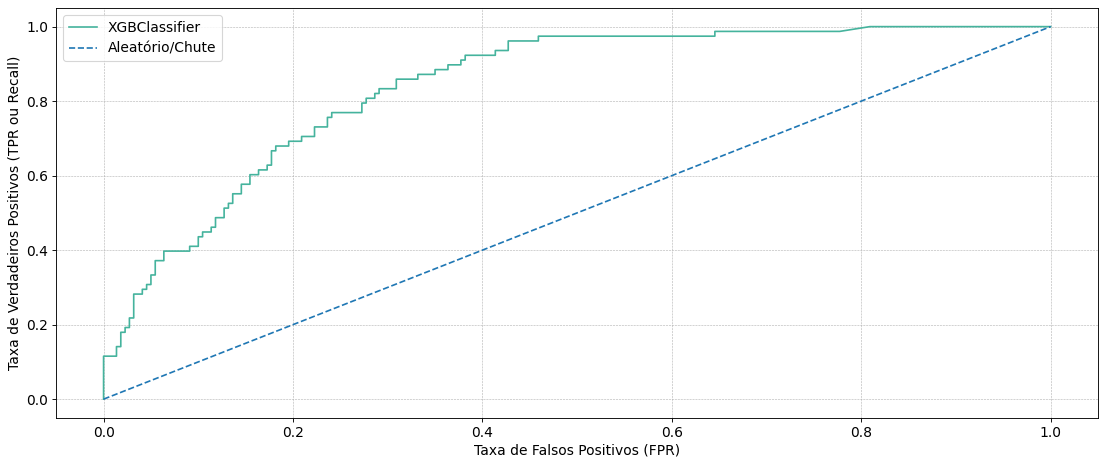

In [53]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)
# plt.title(' Curva Característica de Operação do Receptor (ROC)')
lr_fpr, lr_tpr, thresholds =  roc_curve(y_txt_test.values, model.predict_proba(X_txt_test_idf)[:,1], drop_intermediate=False, pos_label=1)
plt.plot(lr_fpr, lr_tpr, label='XGBClassifier',color='#45B39D')
plt.plot([0, 1], [0,1], linestyle='--', label='Aleatório/Chute')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.legend()
plt.grid(which='major',linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.savefig('./docs/tcc/fig_00600_roc_auc_texto.png')
plt.show()

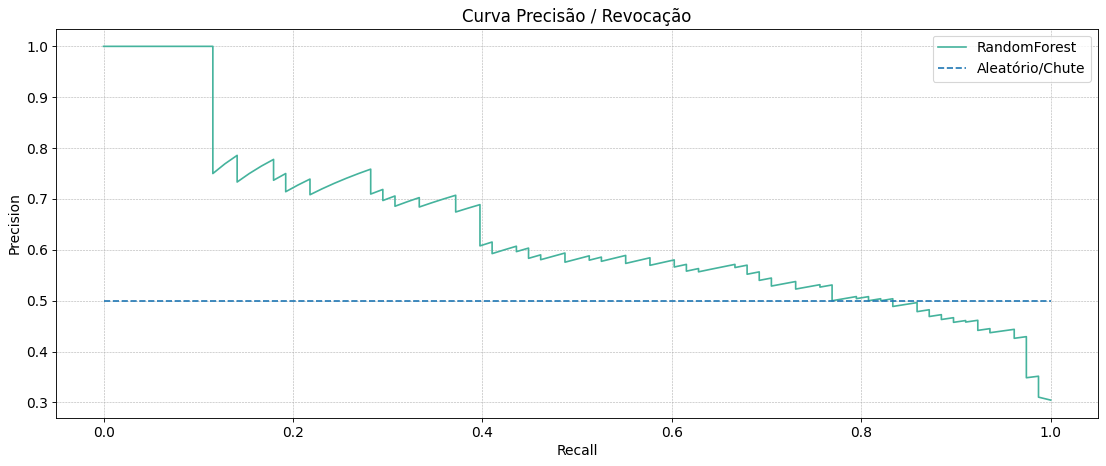

In [54]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)

plt.title('Curva Precisão / Revocação')
lr_precision, lr_recall, thresholds =  precision_recall_curve(y_txt_test.values, model.predict_proba(X_txt_test_idf)[:,1], pos_label=1)
plt.plot(lr_recall, lr_precision, label='RandomForest', color='#45B39D')
plt.plot([0, 1], [0.5,0.5], linestyle='--', label='Aleatório/Chute')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(which='major',linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.savefig('./docs/tcc/fig_00610_pr_auc_dados_estr.png')
plt.show()

In [55]:
pr_auc_score = auc(lr_recall, lr_precision)
pr_auc_score

0.6373586798711441

In [56]:
df_histograma = pd.Series(model.predict_proba(X_txt_test_idf)[:,1]).to_frame().rename(columns={0:'Score'})
df_histograma['Bins'] = pd.cut(df_histograma['Score'], bins=np.arange(0,1.05,0.05))
df_histograma['Y'] = y_txt_test.values
df_histograma['Acertos Thr 0.5'] = df_histograma.apply(lambda x: 1 if (1 if x['Score']>=.5 else 0)==x['Y'] else 0,axis=1)
df_histograma.head()

,Score,Bins,Y,Acertos Thr 0.5
0,0.436929,"(0.4, 0.45]",0,1
1,0.168581,"(0.15, 0.2]",0,1
2,0.157108,"(0.15, 0.2]",0,1
3,0.170780,"(0.15, 0.2]",0,1
4,0.448652,"(0.4, 0.45]",0,1


In [57]:
df_barplot = df_histograma[['Bins','Acertos Thr 0.5']].groupby(['Bins']).apply(lambda x: x['Acertos Thr 0.5'].sum()/x.shape[0]).fillna(0).to_frame().rename(columns={0: 'Acertos (%)'})
df_barplot['Contagem'] = df_histograma[['Bins','Acertos Thr 0.5']].groupby(['Bins']).count()
df_barplot = df_barplot.reset_index()
df_barplot['left'] = df_barplot['Bins'].apply(lambda x: x.left+0.025)
df_barplot

,Bins,Acertos (%),Contagem,left
0,"(0.0, 0.05]",0.000000,0,0.025
1,"(0.05, 0.1]",0.000000,0,0.075
2,"(0.1, 0.15]",1.000000,12,0.125
3,"(0.15, 0.2]",0.976471,85,0.175
4,"(0.2, 0.25]",0.967742,31,0.225
5,"(0.25, 0.3]",0.736842,19,0.275
6,"(0.3, 0.35]",0.739130,23,0.325
7,"(0.35, 0.4]",0.714286,14,0.375
8,"(0.4, 0.45]",0.666667,21,0.425
9,"(0.45, 0.5]",0.428571,14,0.475


In [58]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
N = 20
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(.5,45/256, N)
vals[:, 1] = np.linspace(0, 179/256, N)
vals[:, 2] = np.linspace(0, 157/256, N)
newcmp = ListedColormap(vals)

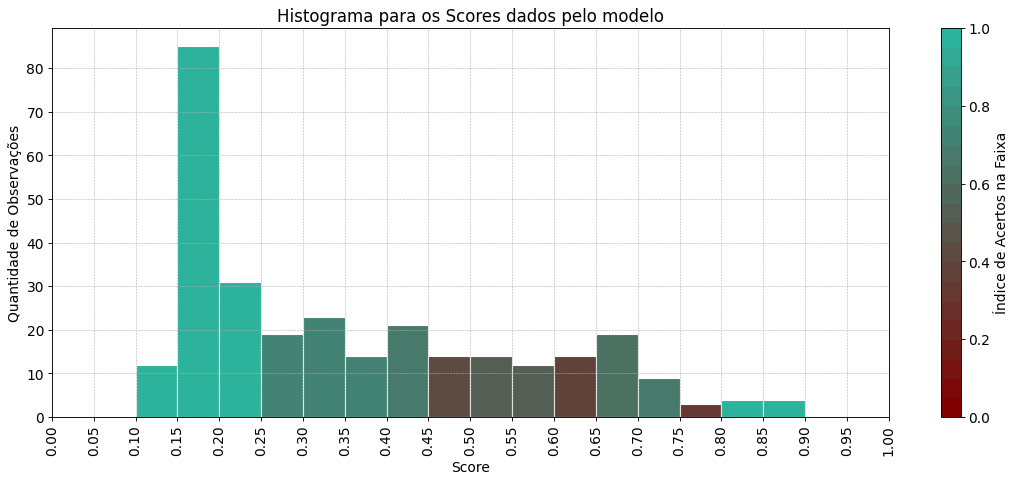

In [59]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)
color='#45B39D'
scalarMappable = ScalarMappable(cmap=newcmp)
plt.bar(df_barplot['left'], df_barplot['Contagem'], width=0.05, color=scalarMappable.cmap(df_barplot['Acertos (%)']), alpha=1, linewidth=1, edgecolor='white')
colorbar = plt.colorbar(scalarMappable)
colorbar.set_label('Índice de Acertos na Faixa')
plt.xlim(0,1)
plt.grid(which='both',linestyle='--', linewidth=0.5)
plt.title('Histograma para os Scores dados pelo modelo')
plt.xlabel('Score')
plt.ylabel('Quantidade de Observações')
plt.tight_layout()
plt.xticks(ticks=np.arange(0,1.05, 0.05), rotation=90)
# plt.savefig('./docs/tcc/fig_00430_pos_prob_dados_estr.png')
plt.show()